In [1]:
#import os, cv2, random
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

In [4]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

Using TensorFlow backend.


In [5]:
import os, cv2, random
import numpy as np
import pandas as pd

TRAIN_DIR = 'data/train/'
TEST_DIR = 'data/test/'

In [6]:
ROWS = 256
COLS = 256
ROWS2 = 64
COLS2 = 64
CHANNELS = 3

In [7]:
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
train_images = train_dogs[:10000] + train_cats[:10000]
random.shuffle(train_images)
test_images =  test_images[:1000]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    b,g,r = cv2.split(img)
    img2 = cv2.merge([r,g,b])
    return cv2.resize(img2, (ROWS2, COLS2), interpolation=cv2.INTER_CUBIC)

def read_image2(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    b,g,r = cv2.split(img)
    img2 = cv2.merge([r,g,b])
    return cv2.resize(img2, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS2, COLS2), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

def prep_data2(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image2(image_file)
        data[i] = image.T
        if i%500 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)
test2 = prep_data2(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 20000
Processed 1000 of 20000
Processed 2000 of 20000
Processed 3000 of 20000
Processed 4000 of 20000
Processed 5000 of 20000
Processed 6000 of 20000
Processed 7000 of 20000
Processed 8000 of 20000
Processed 9000 of 20000
Processed 10000 of 20000
Processed 11000 of 20000
Processed 12000 of 20000
Processed 13000 of 20000
Processed 14000 of 20000
Processed 15000 of 20000
Processed 16000 of 20000
Processed 17000 of 20000
Processed 18000 of 20000
Processed 19000 of 20000
Processed 0 of 1000
Processed 0 of 1000
Processed 500 of 1000
Train shape: (20000, 3, 64, 64)
Test shape: (1000, 3, 64, 64)


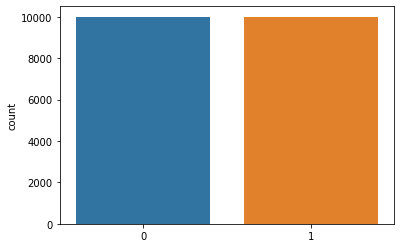

In [8]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)

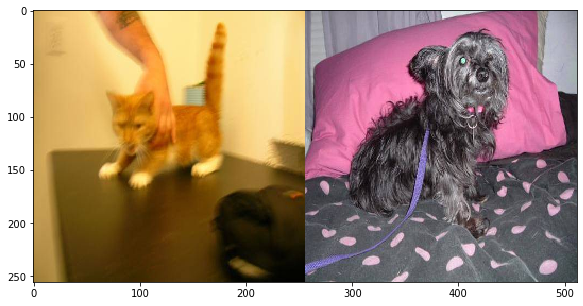

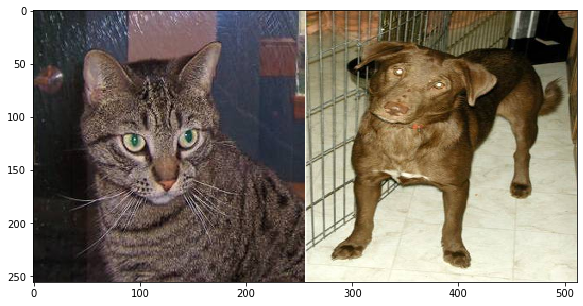

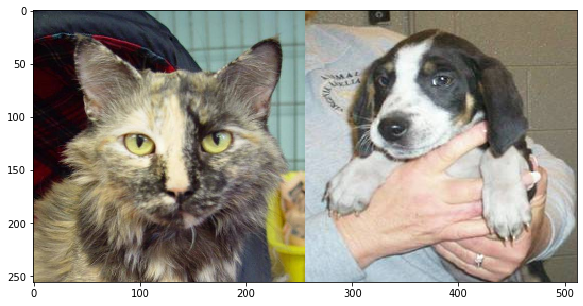

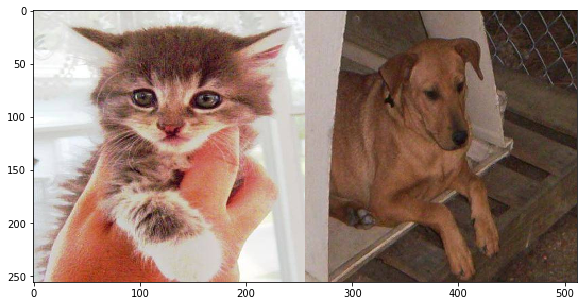

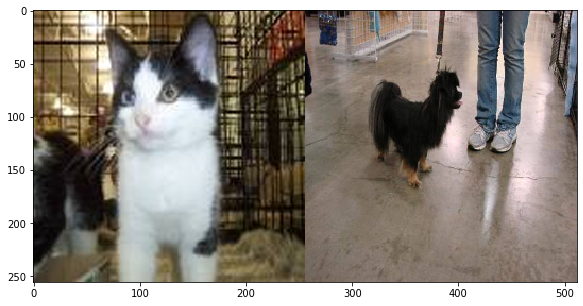

In [9]:
def show_cats_and_dogs(idx):
    cat = read_image2(train_cats[idx])
    dog = read_image2(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,5):
    show_cats_and_dogs(idx)

In [10]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def catdog():
    
    model = Sequential()

    model.add(Conv2D(32, 3, padding='same', input_shape=train.shape[1:], activation='relu'))
    model.add(Conv2D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #print("First layer...")
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #print("Second layer...")
    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #print("Third layer...")
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

    #model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    #model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    #model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #print("Flattening, etc...")
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    print("Compiling model...")
    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

print("Creating model:")
model = catdog()

Instructions for updating:
Colocations handled automatically by placer.
Creating model:
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Compiling model...


running model...
Instructions for updating:
Use tf.cast instead.
Train on 15000 samples, validate on 5000 samples
Epoch 1/10
 - 160s - loss: 0.6952 - acc: 0.5501 - val_loss: 0.8293 - val_acc: 0.5500
Epoch 2/10
 - 161s - loss: 0.6450 - acc: 0.6317 - val_loss: 0.6886 - val_acc: 0.6254
Epoch 3/10
 - 155s - loss: 0.6191 - acc: 0.6617 - val_loss: 0.6383 - val_acc: 0.6294
Epoch 4/10
 - 176s - loss: 0.6005 - acc: 0.6753 - val_loss: 0.6794 - val_acc: 0.6836
Epoch 5/10
 - 158s - loss: 0.5960 - acc: 0.6908 - val_loss: 0.6796 - val_acc: 0.6464
Epoch 6/10
 - 157s - loss: 0.5904 - acc: 0.6925 - val_loss: 0.5957 - val_acc: 0.6848
Epoch 7/10
 - 159s - loss: 0.5845 - acc: 0.7033 - val_loss: 0.6307 - val_acc: 0.6960
Epoch 8/10
 - 155s - loss: 0.5829 - acc: 0.7083 - val_loss: 0.5954 - val_acc: 0.7104
Epoch 9/10
 - 163s - loss: 0.5780 - acc: 0.7145 - val_loss: 0.6748 - val_acc: 0.6786
Epoch 10/10
 - 154s - loss: 0.5728 - acc: 0.7211 - val_loss: 0.6211 - val_acc: 0.6898
making predictions on test set...


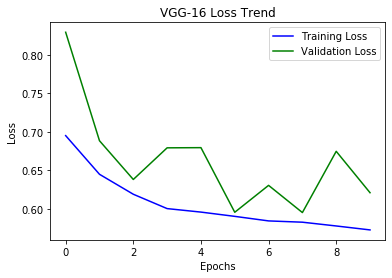

In [11]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

epochs = 10
batch_size = 16

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
       

def run_catdog():
    
    history = LossHistory()
    print("running model...")
    model.fit(train, labels, batch_size=batch_size, epochs=epochs,
              validation_split=0.25, verbose=2, shuffle=True, callbacks=[history, early_stopping])
    
    print("making predictions on test set...")
    predictions = model.predict(test, verbose=0)
    return predictions, history

predictions, history = run_catdog()

loss = history.losses
val_loss = history.val_losses


plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

I am 86.98% sure this is a Cat


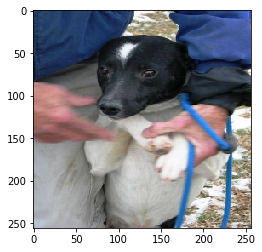

I am 83.01% sure this is a Cat


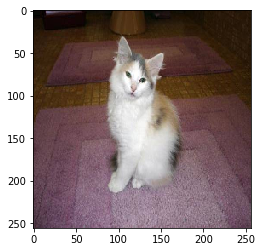

I am 83.84% sure this is a Cat


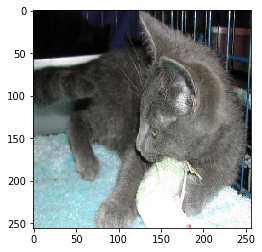

I am 75.79% sure this is a Cat


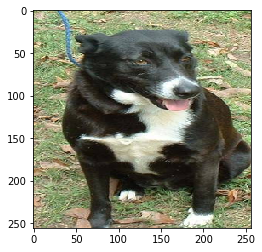

I am 50.71% sure this is a Dog


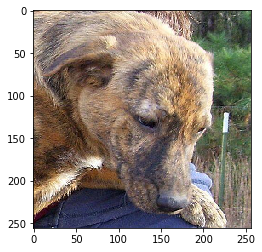

I am 59.42% sure this is a Cat


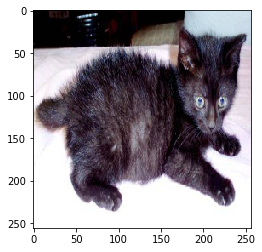

I am 81.41% sure this is a Cat


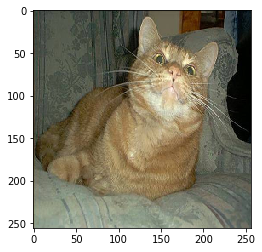

I am 83.21% sure this is a Dog


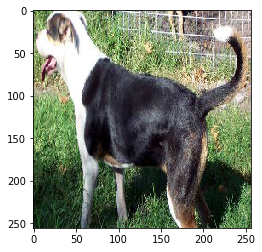

I am 85.32% sure this is a Cat


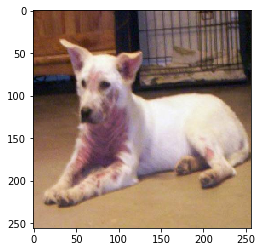

I am 71.57% sure this is a Cat


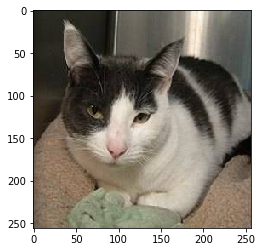

In [12]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test2[i].T)
    plt.show()